# Preparing Data
Change working directory to the directory that has our data. 
Data can be found at 

https://github.com/UrmilaAirsang/Pytorch/tree/main/S12/AssignmentPartB/Assignment12%20images

In [2]:
%cd Assignment12Images

/content/Assignment12Images


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read annotation JSON

JSON can be found here:

https://github.com/UrmilaAirsang/Pytorch/tree/main/S12/AssignmentPartB/Assignment-12.json

In [3]:
import json
from PIL import Image

In [4]:
with open("Assignment-12.json") as f:
  json_dict = json.load(f)

## Explore sample data point

In [5]:
json_dict.keys()

dict_keys(['2Q__ (1).jpg8968', '2Q__ (2).jpg8680', '2Q__ (3).jpg6835', '2Q__ (4).jpg11779', '2Q__ (5).jpg5686', '2Q__ (6).jpg7651', '2Q__.jpg9517', '9k_ (1).jpg12170', '9k_ (2).jpg9368', '9k_ (3).jpg7427', '9k_ (4).jpg7706', '9k_ (5).jpg10166', '9k_ (6).jpg5342', '9k_.jpg6062', 'images (1).jpg10880', 'images (2).jpg8711', 'images (3).jpg7698', 'images (4).jpg5527', 'images (5).jpg9327', 'images (6).jpg8274', 'images (7).jpg12282', 'images (8).jpg6867', 'images (9).jpg6665', 'images (10).jpg10502', 'images (11).jpg7232', 'images (12).jpg8116', 'images (13).jpg8490', 'images (14).jpg6053', 'images (15).jpg4602', 'images (16).jpg7951', 'images (17).jpg6023', 'images (18).jpg9816', 'images (19).jpg3191', 'images (20).jpg5035', 'images (21).jpg6867', 'images (22).jpg5462', 'images (23).jpg5638', 'images (24).jpg9184', 'images (25).jpg8820', 'images (26).jpg13756', 'images (27).jpg8780', 'images (28).jpg5647', 'images (29).jpg14813', 'images (30).jpg11626', 'images (31).jpg12083', 'images (3

In [ ]:
json_dict['2Q__ (1).jpg8968']

{'file_attributes': {'caption': '', 'image_url': '', 'public_domain': 'no'},
 'filename': '2Q__ (1).jpg',
 'regions': [{'region_attributes': {'image_quality': {'frontal': True,
     'good': True,
     'good_illumination': True},
    'name': 'hardhat1',
    'type': 'hardhat'},
   'shape_attributes': {'height': 63,
    'name': 'rect',
    'width': 74,
    'x': 56,
    'y': 14}},
  {'region_attributes': {'image_quality': {'frontal': True,
     'good': True,
     'good_illumination': True},
    'name': 'mask1',
    'type': 'mask'},
   'shape_attributes': {'height': 44,
    'name': 'rect',
    'width': 46,
    'x': 71,
    'y': 79}}],
 'size': 8968}

## Prepare a dataframe from this json using filename,	img_w,	img_h,	class,	H,	W,	CX,	CY

In [7]:
bbox_metadata_dict_list = []

for file_key in json_dict:
    img = Image.open(json_dict[file_key]['filename'])
    for region in json_dict[file_key]['regions']:
        dp = {}
        dp['file'] = json_dict[file_key]['filename']
        dp['img_w'], dp['img_h'] = img.size
        dp['class'] = region['region_attributes']['type']
        dp['H'] = region['shape_attributes']['height']
        dp['W'] = region['shape_attributes']['width']
        dp['CX'] = region['shape_attributes']['x']
        dp['CY'] = region['shape_attributes']['y']
        bbox_metadata_dict_list.append(dp)



In [10]:
import pandas as pd
df = pd.DataFrame(bbox_metadata_dict_list)
print(df.head())
print(df.shape)

           file  img_w  img_h    class   H    W   CX  CY
0  2Q__ (1).jpg    192    263  hardhat  63   74   56  14
1  2Q__ (1).jpg    192    263     mask  44   46   71  79
2  2Q__ (2).jpg    262    192  hardhat  40   67  120  15
3  2Q__ (2).jpg    262    192     mask  38   41  135  61
4  2Q__ (2).jpg    262    192     vest  78  130   87  95
(249, 8)


## Finding the value of K (optimum #clusters)

## Normalizing
Here we normalize the height and width of bounding box annotations with the respective height and width of the corresponding image

In [11]:
df['h'] = df['H']/df['img_h']
df['w'] = df['W']/df['img_w']
df.head()

file  img_w  img_h    class   H    W   CX  CY         h         w
0  2Q__ (1).jpg    192    263  hardhat  63   74   56  14  0.239544  0.385417
1  2Q__ (1).jpg    192    263     mask  44   46   71  79  0.167300  0.239583
2  2Q__ (2).jpg    262    192  hardhat  40   67  120  15  0.208333  0.255725
3  2Q__ (2).jpg    262    192     mask  38   41  135  61  0.197917  0.156489
4  2Q__ (2).jpg    262    192     vest  78  130   87  95  0.406250  0.496183

## Plot normalized values of height and width

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

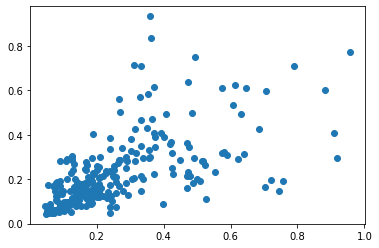

In [13]:
plt.scatter(df['h'], df['w'])

# Find K

WCSS is the sum of squares of the distances of each data point in all clusters to their respective centroids

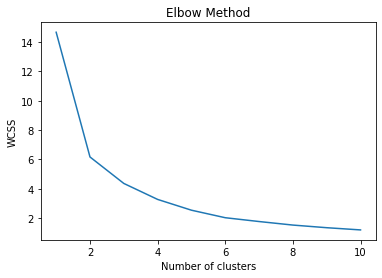

In [14]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit((df[['h', 'w']]))
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Looking at the above graph k=3 seems appropriate.

Can experiment with k=4 also

## Centroids with K=3 (preferred)

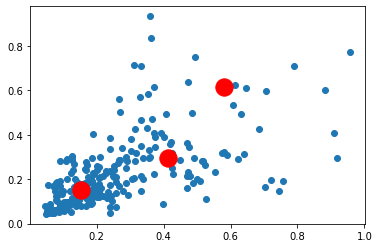

In [15]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df[['h', 'w']])
plt.scatter(df['h'], df['w'])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

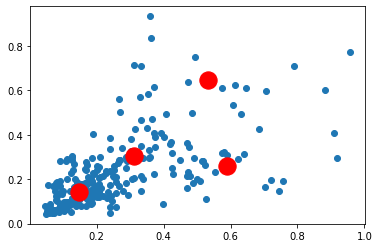

In [16]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df[['h', 'w']])
plt.scatter(df['h'], df['w'])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()